# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

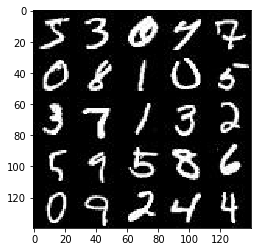

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

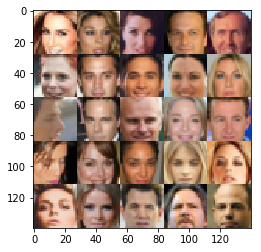

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/erickdiaz/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, 
                                shape=(None, image_width, image_height, image_channels),
                                name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha*x,x)

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = leaky_relu(conv_layer1)
        
        conv_layer2 = tf.layers.conv2d(conv_layer1, 128, 5, strides=2, padding='same')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=True)
        relu2 = leaky_relu(conv_layer2)
        
        conv_layer3 = tf.layers.conv2d(conv_layer2, 256, 5, strides=2, padding='same')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=True)
        relu3 = leaky_relu(conv_layer3)
        
        conv_layer4 = tf.layers.conv2d(conv_layer3, 512, 5, strides=2, padding='same')
        conv_layer4 = tf.layers.batch_normalization(conv_layer4)
        relu4 = leaky_relu(conv_layer4)
        
        #Flat
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        #Logits
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        #Fully connected layer
        fully_conn = tf.layers.dense(z, 7*7*512)
        fully_conn = tf.reshape(fully_conn, (-1,7,7,512))
        fully_conn = tf.layers.batch_normalization(fully_conn, training=is_train)
        fully_conn = leaky_relu(fully_conn)
        # 7x7x512

        #Convolutions
        conv_layer1 = tf.layers.conv2d_transpose(fully_conn, 256, 3, strides=2, padding='same')
        conv_layer1 = tf.layers.batch_normalization(conv_layer1, training=is_train)
        conv_layer1 = leaky_relu(conv_layer1)
        # 14x14x256

        conv_layer2 = tf.layers.conv2d_transpose(conv_layer1, 128, 3, strides=1, padding='same')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=is_train)
        conv_layer2 = leaky_relu(conv_layer2)
        # 14x14x128

        conv_layer3 = tf.layers.conv2d_transpose(conv_layer2, 64, 3, strides=2, padding='same')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=is_train)
        conv_layer3 = leaky_relu(conv_layer3)
        # 28x28x64   

        # Output layer
        logits = tf.layers.conv2d_transpose(conv_layer3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_dim 

        gen_out = tf.tanh(logits)

    return gen_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Label smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=(tf.ones_like(d_model_real)*(1-smooth)) ))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))

    dicriminator_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    
    return dicriminator_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("Shape:", data_shape)
    print("Learning rate:", learning_rate)
    img_width = data_shape[1]
    img_height = data_shape[2]
    img_channels = data_shape[3]
    
    # Init GAN
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    print(input_real)
    print(input_z)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Train
    steps = 0
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #adjust the range
                batch_images *= 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    d_loss_train = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    g_loss_train = g_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Shape: (60000, 28, 28, 1)
Learning rate: 0.0002
Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("input_z:0", shape=(?, 128), dtype=float32)
Epoch 1/2... Discriminator Loss: 2.8342... Generator Loss: 0.1343
Epoch 1/2... Discriminator Loss: 0.5091... Generator Loss: 2.1285
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 4.8003
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 2.8912
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.3688
Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 2.8815
Epoch 1/2... Discriminator Loss: 0.4246... Generator Loss: 2.7007
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.9983
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 2.0820... Generator Loss: 0.5156


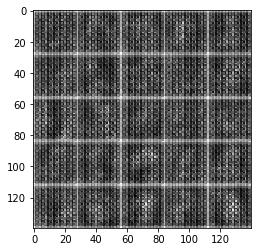

Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.9999... Generator Loss: 0.2920
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 1.2956
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 1.7503... Generator Loss: 0.4489
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 1.0368
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.7630


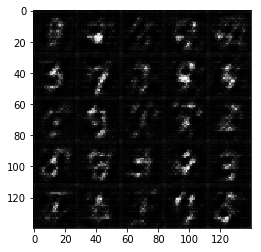

Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.9106
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 1.0568


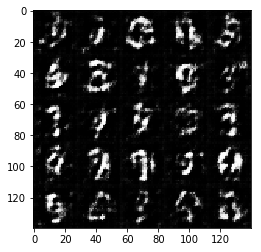

Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.0537
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.8899
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.7480
Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.8518


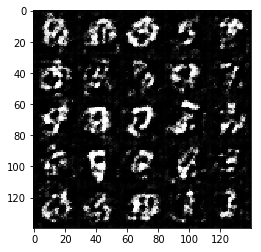

Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.0174
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.8714


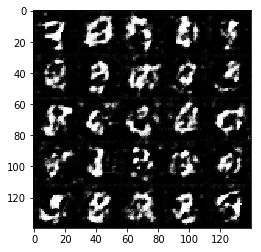

Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.0602
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.8373
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 1.0440
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.9763
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.9222
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 1.1312


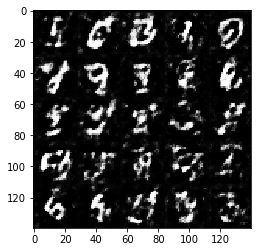

Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.9289
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 1.1710
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 1.1232
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 1.0184


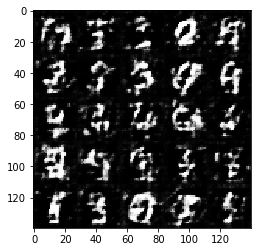

Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.1887
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 1.0633
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.8342


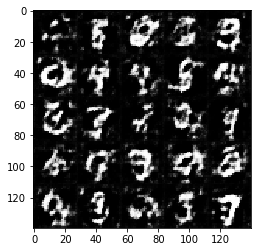

Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.4530
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.2831
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.0465
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 1.0030
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.1006


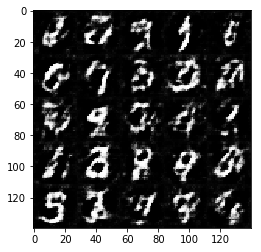

Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.0106
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 1.1068
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.9277


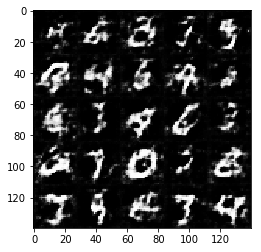

Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.2355... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.9407


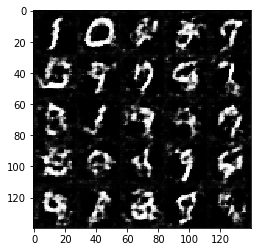

Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 1.2631
Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.6575
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.9463


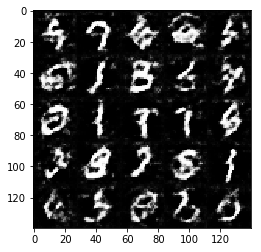

Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 1.1028
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 1.1372
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 1.1838
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.8011


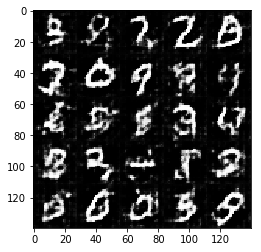

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 0.9299
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 1.1762
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 1.1511
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.9555


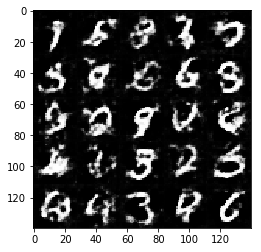

Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.9911
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.9353


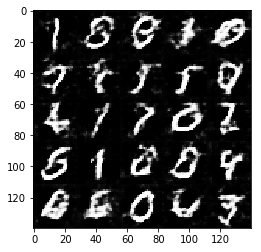

Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.9162
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.8753


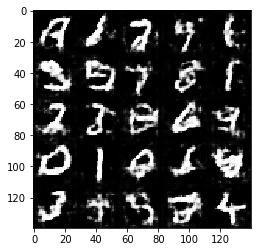

Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 0.9782
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 1.0590
Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.7932


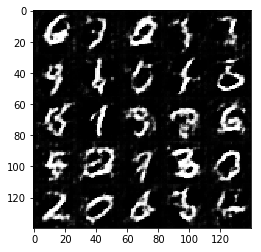

Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 1.0948
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.3071... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 1.0388
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.8674


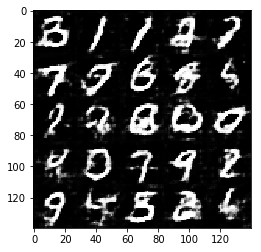

Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.9547
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.9963


In [43]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 24

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.